In [1]:
import dynamiqs as dq
import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import cvxpy as cp

# Task A: Generate Wigner Functions

In this task, we'll prepare different states with dynamiqs and we'll plot their Wigner functions for visualization. The plots will also allow us to check that we prepared the correct states.

## Fock State

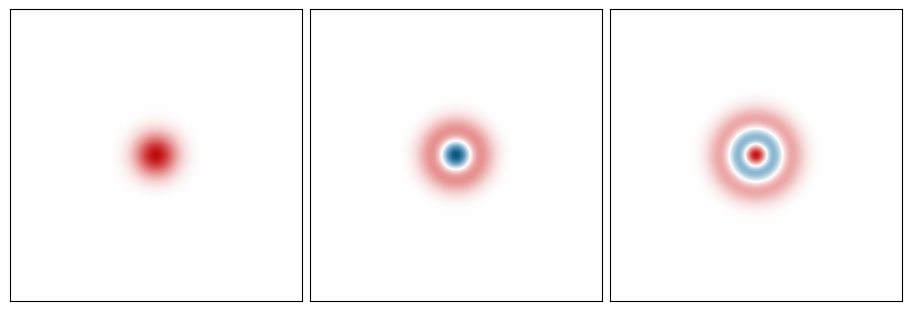

In [5]:
fockstates = [dq.fock(3, i) for i in range(3)] 
dq.plot.wigner_mosaic(fockstates)

## Coherent State

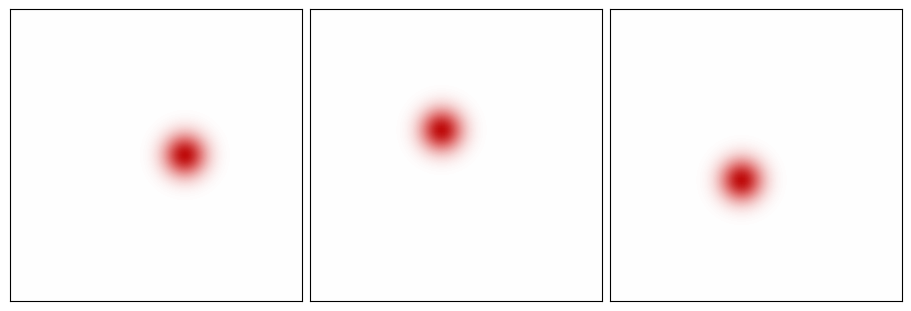

In [2]:
coherentstates = [dq.coherent(100, np.exp(2j *np.pi/3 * i)) for i in range(3)]
dq.plot.wigner_mosaic(coherentstates)

## Cat States

In [4]:
def ncat(n, alpha, dim): # function that returns an n-Cat state with a given phase alpha
    cat = dq.coherent(dim, alpha)
    for k in range(1, n):
        cat += dq.coherent(dim, jnp.exp(2j*jnp.pi*k/n)*alpha)
    return cat/dq.norm(cat)

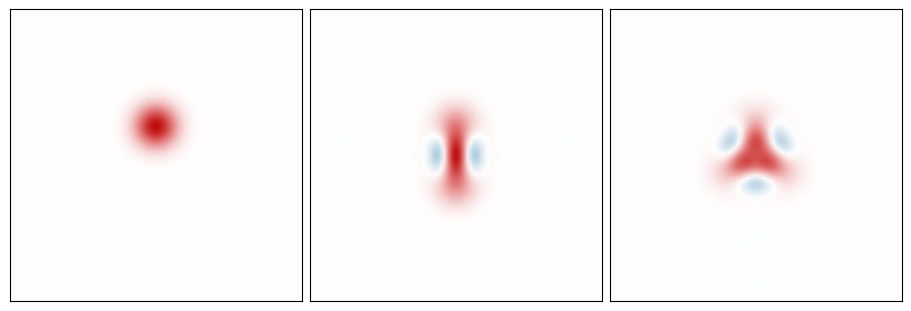

In [5]:
catstates = [ncat(i, np.exp(1j *np.pi/2), 100) for i in range(1,4)]
dq.plot.wigner_mosaic(catstates)

## Dissipative Cat State

In [6]:
a, b = dq.destroy(10, 10)
g2 = 1
eps = -4
kappa = 10
T = 4
ntsave = 201
rho = dq.fock_dm((10,10),(0,0))
H = np.conj(g2)*(a.dag() @ a.dag() @ b) + g2*(a @ a @ b.dag()) + np.conj(eps)*b+ eps*b.dag()
jump_ops = [b]
tsave = jnp.linspace(0.0, T, ntsave)
result = dq.mesolve(H, jump_ops, rho, tsave)
gif = dq.plot.wigner_gif(result.states, ymax=3.0, gif_duration=4.0)

|██████████| 100.0% ◆ elapsed 237.62ms ◆ remaining 0.00ms  
100%|██████████| 40/40 [00:11<00:00,  3.40it/s]


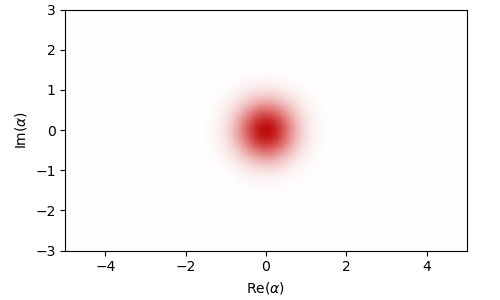

In [7]:
gif

# Task B: Density Matrix Reconstruction from Wigner Data

In this task, we implement a pipeline to reconstruct the density matrix from Wigner function measurements. To do this, we first try to reconstruct the known states, we just prepared in task A. We then evaluate the fits by calculate the fidelity and relative entropy and compare them for the different states.

In [3]:
def wigner_from_state(rho_in,
           x_vec, y_vec):
    
    xv, yv = jnp.meshgrid(x_vec, y_vec)
    #Define Wigner Function
    def w(state, xv, xy):
        return jnp.pi/2*dq.wigner(state, xmax = xv.max(), ymax = yv.max(), npixels = len(xv))[2]
    
    #============================================================
    #Define Preliminary Data
    dim = rho_in.dims[0]
    fac = 10
    
    #Check if dim has correct properties:
    if type(dim)!=int:
        raise('Dimension is not integer')
    
    #Compute measurement data
    w_k = w(rho_in, xv, yv).flatten()
    
    #Define Observables
    alpha = (xv.T + yv.T*1j).flatten()
    E_list = (dq.displace(dim*fac, alpha)@dq.parity(dim*fac)@dq.dag(dq.displace(dim*fac, alpha))).data[:, :dim, :dim]
    
    #===============================================================
    #Inititalize Optimization
    
    # Define variable
    rho = cp.Variable((dim, dim), hermitian=True)
    
    # Objective
    exprs = cp.hstack([cp.real(cp.trace(E@rho)) - k for E, k in zip(E_list, w_k)])
    objective = cp.Minimize(cp.sum_squares(exprs))
    # print(objective)
    
    # Constraints
    constraints = [rho >> 0, cp.trace(rho) == 1]
    
    # Solve problem
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.MOSEK)
    
    # Output estimated density matrix
    rho_out = rho.value
    #Compute Fidelity
    fidelity = dq.fidelity(rho_in, rho_out)
    
    return rho_out, fidelity

In [4]:
x_vec = jnp.linspace(-2, 2, 10)
y_vec = jnp.linspace(-2, 2, 10)
for fock_state in fockstates:
    rho_out, fidelity = wigner_from_state(fock_state, x_vec, y_vec)
    states = [fock_state@dq.dag(fock_state), rho_out]
    dq.plot.wigner_mosaic(states)

NameError: name 'fockstates' is not defined

In [ ]:
for coherent_state in coherentstates:
    rho_out, fidelity = wigner_from_state(coherent_state, x_vec, y_vec)
    states = [coherent_state@dq.dag(coherent_state), rho_out]
    dq.plot.wigner_mosaic(states)

In [ ]:
for cat_state in catstates:
    rho_out, fidelity = wigner_from_state(cat_state, x_vec, y_vec)
    states = [cat_state@dq.dag(cat_state), rho_out]
    dq.plot.wigner_mosaic(states)

# Task C: Robustness of the fit

In this task, we check the robustness of the fit for noisy data. First, we try by adding gaussian noise to the previously generated Wigner functions. We can then plot how the fidelity changes as we increase noise. Finally, we will try to reconstruct the density matrix from real experimental data.

In [ ]:
def add_gaussian_noise(wigner, sigma):
    noise = sigma*jax.random.normal(jax.random.key(0), wigner.shape)
    return jnp.add(wigner, noise)

def wigner_from_state(rho_in,
           xv, yv,
           sigma,
           optimization_type = 'Least-Squares'):
    
    #Define Wigner Function
    def w(state, xv, xy):
        return jnp.pi/2*dq.wigner(state, xmax = xv.max(), ymax = yv.max(), npixels = len(xv))[2]
    
    #============================================================
    #Define Preliminary Data
    dim = rho_in.dims[0]
    if dim<5:
        fac = 10
    else:
        fac = 5
    
    #Check if dim has correct properties:
    if type(dim)!=int:
        raise('Dimension is not integer')
    
    #Compute measurement data
    w_k = add_gaussian_noise(w(rho_in, xv, yv), sigma).flatten()
    
    #Define Observables
    alpha = (xv.T + yv.T*1j).flatten()
    E_list = (dq.displace(dim*fac, alpha)@dq.parity(dim*fac)@dq.dag(dq.displace(dim*fac, alpha))).data[:, :dim, :dim]
    
    #===============================================================
    #Inititalize Optimization
    
    # Define variable
    rho = cp.Variable((dim, dim), hermitian=True)
    
    # Objective
    exprs = cp.hstack([cp.real(cp.trace(E@rho)) - k for E, k in zip(E_list, w_k)])
    
    if optimization_type == 'Least-Squares':
        objective = cp.Minimize(cp.sum_squares(exprs))
    if optimization_type == 'Huber':
        objective = cp.Minimize(cp.sum(cp.huber(exprs)))
    
    # print(objective)
    
    # Constraints
    constraints = [rho >> 0, cp.trace(rho) == 1]
    
    # Solve problem
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.MOSEK)
    
    # Output estimated density matrix
    rho_out = rho.value
    #Compute Fidelity
    fidelity = dq.fidelity(rho_in, rho_out)
    
    return rho_out, fidelity